In [13]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
#from IPython.display import display, clear_output
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score as sk_f1_score
import itertools

In [14]:
data = pd.read_csv('data/chips.txt', header=None, names=['X', 'Y', 'Class'])
data = data.sample(frac=1, random_state=0)
xs = data[['X', 'Y']].values
ys = data['Class'].values

xs = StandardScaler().fit_transform(xs)

In [15]:
def f1_score(predicted, true):
    #print (len(predicted))
    #print (len(true))
    tp = ((predicted == true) * (predicted == 1)).sum()
    tn = ((predicted == true) * (predicted != 1)).sum()
    fp = ((predicted != true) * (predicted == 1)).sum()
    fn = ((predicted != true) * (predicted != 1)).sum()
    p = tp*1.0/max(1, tp+fp)
    r = tp*1.0/max(1, tp+fn)
    return (2*p*r/max(1, p+r), tp, fn, fp, tn)

In [16]:
def print_f1Nmatrix(t):
    print("confusion matrix")
    print("    T   F")
    print("P ", t[1], t[3])
    print("N ", t[4], t[2])
    print("f1_score = ", t[0])

In [17]:
def shuffle(X, y):
    p = np.arange(0, X.shape[0])
    np.random.shuffle(p)
    return (X[p], y[p])

np.random.seed(42)
#xs, ys = shuffle(xs, ys)

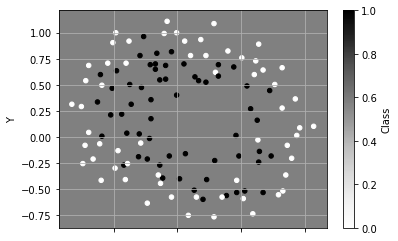

In [18]:
plot1 = data.plot(kind='scatter', x='X', y='Y', c='Class', grid=True)
plot1.set_facecolor("gray")

In [19]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(xs = data['X'], ys = data['Y'], zs = data['R'], c=data['Class'])

In [20]:
def split(X, y, part=10):
    p = X.shape[0] // part
    return X[p:], y[p:], X[:p], y[:p]

In [21]:
def space_function(x):
    return np.array([x[0], x[1], x[0]**2+x[1]**2, x[0]**2+2*x[0]*x[1]+x[1]**2])    


In [22]:
from sklearn.cross_validation import KFold
def kf_cross_validation(regressor, xs, ys, n_fold=10, kf=None, **params):
    measure = lambda x, y: f1_score(x, y)[0]
    kf_sum = 0
    f1_scores = []
    if kf is None:
        kf = KFold(len(xs), n_fold, True, 0)
    fold_num = 0
    P = 100
    for train_i, test_i in kf:
        regressor.fit(xs[train_i], ys[train_i], **params)
        predicted = regressor.predict(xs[test_i])
        meas = measure(predicted, ys[test_i])
        f1_scores.append(meas*P)
        kf_sum += meas
        fold_num += 1        
    return (kf_sum/len(kf), np.array(f1_scores))

In [23]:
# create a mesh to plot in
def draw_mesh(svm, xs, ys):
    x_min, x_max = xs[:, 0].min() - 1, xs[:, 0].max() + 1
    y_min, y_max = xs[:, 1].min() - 1, xs[:, 1].max() + 1
    hx = (x_max - x_min) / 100
    hy = (y_max - y_min) / 100
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx),
    np.arange(y_min, y_max, hy))
    #print (y_min, y_max, h)
    plt.subplot(1, 1, 1)    
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(xs[:, 0], xs[:, 1], c=ys, cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.title('SVC with linear kernel')
    plt.show()

In [24]:
def kernel_simple(x, y):
    return np.dot(x, y)

def kernel_poly(x, y):
    return np.dot(x, y) ** 2

def kernel_poly_1(x, y):
    return (np.dot(x,y) + 1)**2

# 1
# 0.5
def kernel_radial(x, y):
    return np.exp(-(np.linalg.norm(x - y) ** 2) / 1)

class SVM(BaseEstimator):
    def __init__(self, C, K = kernel_simple):
        self.K = K        
        self.C = C        
        
    def get_params(self, deep=False):
        
        return {"C": self.C,
                "K": self.K, 
                "l": self.l,
                "X": self.X,
                "Y": self.Y
               }

    def set_params(self, **params):
        self.C = params["C"]
        self.K = params["K"] 
        self.Y = params["X"] 
        self.Y = params["Y"]
        self.l = params["l"] 
        
    def fit(self, X, Y):
        N = len(X)
        Y = np.apply_along_axis(lambda t: 2 * t - 1, 0, Y)        

        construct_H = lambda i, j: self.K(X[i], X[j]) * Y[i] * Y[j]
        H = np.fromfunction(np.vectorize(construct_H), (N, N), dtype=int)
        c = -np.ones(N)        
        x0 = np.ones(N)
        cons = [ {"type": "ineq", "fun": lambda x: self.C * np.ones(N) - x, "jac": lambda x: -np.eye(N)}
               , {"type": "ineq", "fun": lambda x: x,                       "jac": lambda x:  np.eye(N)}
               , {"type": "eq",   "fun": lambda x: np.dot(Y, x),      "jac": lambda x: Y} ]
        opt = {"disp": False}

        # solve constrained minimization problem using quadratic programming solver
        loss = lambda x: 0.5 * np.dot(x.T, np.dot(H, x)) + np.dot(c, x)
        jac = lambda x: np.dot(x.T, H) + c
        res = sp.optimize.minimize(loss, x0, jac=jac, constraints=cons, method="SLSQP", options=opt)

        # find w, w0
        self.w = np.dot(res.x * Y, X)
        self.l = res.x * Y
        self.X = X
        self.Y = Y        
        for i, w_i in enumerate(res.x):
            if w_i > 0:
                self.w0 = self.K(self.w, X[i]) - Y[i]
                break
    
    def predict(self, x):                
        n = len(x)
        res = [-self.w0] * n        
        for j in range(n):            
            res[j] += np.dot(self.l, 
                             np.apply_along_axis(lambda t : self.K(t, x[j]), 1, self.X))
            
        return (np.sign(res)  + 1)/2        

In [25]:
#svm = SVM(C = 10, K = kernel_simple)
#svm.fit(xs, ys)
#pr = svm.predict(xs)
#print_f1Nmatrix(f1_score(pr, ys))

In [26]:
print("phi (x, y, x**2+y**2, 2xy)")
for C in [1, 10, 100, 500]:
    svm = SVM(C = C, K = kernel_radial )
    print("C =", C)    
    print("f1_score =", kf_cross_validation(svm, xs, ys)[0])        
    print("--------------------------------------------------")

phi (x, y, x**2+y**2, 2xy)
C = 1
f1_score = 0.660970695971
--------------------------------------------------
C = 10
f1_score = 0.792472558401
--------------------------------------------------
C = 100
f1_score = 0.713153235653
--------------------------------------------------
C = 500
f1_score = 0.678537151703
--------------------------------------------------


In [27]:
best_c = 10
best_f1_sc = 0
for ic in range(8, 12):
    svm = SVM(C = ic, K = kernel_radial )
    f1_sc_t = kf_cross_validation(svm, xs, ys)[0];
    if (f1_sc_t > best_f1_sc):
        best_c = ic
        best_f1_sc = f1_sc_t

In [28]:
print("Full dataset, C = ", best_c)
svm = SVM(C = best_c, K = kernel_radial)
svm.fit(xs, ys)
prediction_svm = svm.predict(xs)
print_f1Nmatrix(f1_score(prediction_svm, ys))
print("--------------------------------------------------")

Full dataset, C =  11
confusion matrix
    T   F
P  55 14
N  46 3
f1_score =  0.866141732283
--------------------------------------------------


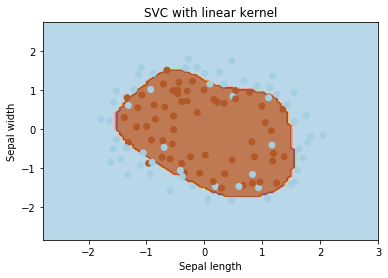

In [29]:
draw_mesh(svm, xs, ys)

In [ ]:
def wilcoxon(x, y):
    assert len(x) == len(y)
    d = x - y
    d = np.compress(np.not_equal(d, 0), d, axis=-1)
    count = len(d)  
    r = np.sort(abs(d))    
    nr = len(r)
    for i in range(0, nr):
        j = i
        while j < nr and r[i] == r[j]:
            j += 1
        r[i:j] = (j*(j-1)/2 - i*(i-1)/2) / (j - i)    
    W = sum(r * np.sign(d))
    z_score = W / np.sqrt(nr*(nr+1)*(2*nr+1)/6)
    return W, z_score


In [ ]:
import knn
n_fold = 7
kf = KFold(len(xs), n_fold, True, 7)

knn = knn.KNN()
svm = SVM(C = best_c, K = kernel_radial)

f1_knn, f1_scoresKnn = kf_cross_validation(knn, xs, ys, kf=kf, k=3, weight_f='uniform', metric_f='l2')
print("KNN f1_score:", f1_knn)
f1_svm, f1_scoresSvm = kf_cross_validation(svm, xs, ys, kf=kf)
print("SVM f1_score:", f1_svm)

KNN f1_score: 0.722972203235


In [ ]:
print("Wilcoxon")
wilcoxon(f1_scoresSvm, f1_scoresKnn)

In [ ]:
pValueTable =[
[ 0, 0.995,0.99,0.975,   0.95, 0.9,  0.1,  0.05,0.025,0.01,0.005],
[ 1,  0,0 ,0.001, 0.004 ,0.016,2.706, 3.841, 5.024, 6.635, 7.879],
[ 2, 0.01 , 0.02 ,0.051,0.103,0.211,4.605 ,5.991  ,7.378  ,9.21   ,10.597],
[ 3, 0.072, 0.115,0.216,0.352,0.584,6.251 ,7.815  ,9.348  ,11.345 ,12.838],
[ 4, 0.207, 0.297,0.484,0.711,1.064,7.779 ,9.488  ,11.143 ,13.277 ,14.86],
[ 5, 0.412, 0.554,0.831,1.145,1.61 ,9.236 ,11.07  ,12.833 ,15.086 ,16.75],
[ 6, 0.676, 0.872,1.237,1.635,2.204,10.645, 12.592, 14.449, 16.812, 18.548],
[ 7, 0.989, 1.239,1.69 ,2.167,2.833,12.017, 14.067, 16.013, 18.475, 20.278],
[ 8, 1.344, 1.646,2.18 ,2.733,3.49 ,13.362, 15.507, 17.535, 20.09 , 21.955],
[ 9, 1.735, 2.088,2.7,  3.325,4.168,14.684, 16.919, 19.023, 21.666, 23.589],
[ 10, 2.156,2.558,3.247,3.94 ,4.865,15.989, 18.307, 20.483, 23.209, 25.188],
[ 11, 2.603,3.053,3.816,4.575,5.578,17.275, 19.675, 21.92 ,24.725 ,26.757]]

def khiSquare(exp, obs):
    x2 = ((obs-exp)**2/exp).sum()
    print("x^2 =", x2)
    
    r = len(exp) - 1
    j = 1
    while (j < len(pValueTable[r]) - 1 and x2 > pValueTable[r][j]):
        j += 1
    return pValueTable[0][j]

print("pValue")
print(khiSquare(f1_scoresKnn, f1_scoresSvm))